In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import time
import calendar
import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import psycopg2
import sklearn
import sklearn.ensemble as ens
from sklearn import preprocessing, metrics, cluster
from scipy import stats
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters

sns.set()
colours = sns.color_palette("husl", 8)
sns.set_palette(sns.color_palette(colours))
register_matplotlib_converters()

# Load Data

In [59]:
data = {}
routes = ["452", "9", "52", "267", "277", "7", "14", "35", "37", "69", "328", "6"]

b_452 = pd.read_csv("data/452 07-04-20.csv")
b_52 = pd.read_csv("data/52 07-04-20.csv")
b_7 = pd.read_csv("data/7 07-04-20.csv")
b_14 = pd.read_csv("data/14 07-04-20.csv")
b_9 = pd.read_csv("data/9 07-04-20.csv")
b_328 = pd.read_csv("data/328 07-04-20.csv")
b_69 = pd.read_csv("data/69 07-04-20.csv")
b_35 = pd.read_csv("data/35 07-04-20.csv")
b_37 = pd.read_csv("data/37 07-04-20.csv")
b_267 = pd.read_csv("data/267 07-04-20.csv")
b_277 = pd.read_csv("data/277 07-04-20.csv")
b_6 = pd.read_csv("data/6 07-04-20.csv")

data["452"] = b_452
data["52"] = b_52
data["7"] = b_7
data["9"] = b_9
data["14"] = b_14
data["328"] = b_328
data["267"] = b_267
data["277"] = b_277
data["35"] = b_35
data["37"] = b_37
data["69"] = b_69
data["6"] = b_6

# need to swap the inbound and outbound labels for data before 12/05/20 because 
# I noted them down wrong from the data collection stage
def init_explore(df, route):
    print("BUS ROUTE: ", route)
    print("Shape: ", df.shape)
    df = df.drop(columns = "arrived")
    
    df.loc[df['direction'] == 'out', 'direction'] = 'inbound'
    df.loc[df['direction'] == 'in', 'direction'] = 'outbound'
    df = df[["bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
    return df

In [60]:
def add_extra_data(route):
    if route != "6":
        more = pd.read_csv("data/" + route + " 22-04-20.csv")
        more.loc[more['arrived'] == 1, 'arrived'] = True
        more = more[["arrived", "bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
        data[route] = data[route].append(more, ignore_index = True)
    
    more = pd.read_csv("data/" + route + " 12-05-20.csv")
    more.loc[more['arrived'] == 1, 'arrived'] = True
    more = more[["arrived", "bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
    data[route] = data[route].append(more, ignore_index = True)

In [61]:
for route in routes:
    add_extra_data(route)

In [62]:
for route in routes:
    data[route] = init_explore(data[route], route)

BUS ROUTE:  452
Shape:  (56938, 6)
BUS ROUTE:  9
Shape:  (49935, 6)
BUS ROUTE:  52
Shape:  (110632, 6)
BUS ROUTE:  267
Shape:  (50939, 6)
BUS ROUTE:  277
Shape:  (71103, 6)
BUS ROUTE:  7
Shape:  (43271, 6)
BUS ROUTE:  14
Shape:  (80413, 6)
BUS ROUTE:  35
Shape:  (50120, 6)
BUS ROUTE:  37
Shape:  (78808, 6)
BUS ROUTE:  69
Shape:  (53844, 6)
BUS ROUTE:  328
Shape:  (41514, 6)
BUS ROUTE:  6
Shape:  (84330, 6)


In [63]:
import json

stops_in_sequence_inbound = {}
stops_in_sequence_outbound = {}

for r in routes:
    with urllib.request.urlopen("https://api.tfl.gov.uk/Line/" + r + "/Route/Sequence/inbound") as api:
        print("Making API call to get all stops on route ", r)
        json_data = json.loads(api.read().decode())
        seq = json_data.get("stopPointSequences")
        stops = []
        for s in seq:
            for stop in s.get("stopPoint"):
                name = stop.get("name")
                stops.append(name)
        stops_in_sequence_inbound[r] = stops
        
    with urllib.request.urlopen("https://api.tfl.gov.uk/Line/" + r + "/Route/Sequence/outbound") as api:
        print("Making API call to get all stops on route ", r)
        json_data = json.loads(api.read().decode())
        seq = json_data.get("stopPointSequences")
        stops = []
        for s in seq:
            for stop in s.get("stopPoint"):
                name = stop.get("name")
                stops.append(name)
        stops_in_sequence_outbound[r] = stops
        
print(stops_in_sequence_inbound.get("52"))

Making API call to get all stops on route  452
Making API call to get all stops on route  452
Making API call to get all stops on route  9
Making API call to get all stops on route  9
Making API call to get all stops on route  52
Making API call to get all stops on route  52
Making API call to get all stops on route  267
Making API call to get all stops on route  267
Making API call to get all stops on route  277
Making API call to get all stops on route  277
Making API call to get all stops on route  7
Making API call to get all stops on route  7
Making API call to get all stops on route  14
Making API call to get all stops on route  14
Making API call to get all stops on route  35
Making API call to get all stops on route  35
Making API call to get all stops on route  37
Making API call to get all stops on route  37
Making API call to get all stops on route  69
Making API call to get all stops on route  69
Making API call to get all stops on route  328
Making API call to get all stop

# Data Analytics

## Helper Functions

In [6]:
def convert_time_to_datetime(given_time):
    year = int(given_time[:4])
    month = int(given_time[5:7])
    day = int(given_time[8:10])
    hour = int(given_time[11:13])
    minute = int(given_time[14:16])
    second = int(given_time[17:19])

    date_time = dt.datetime(year, month, day, hour, minute, second)
    return date_time
    
def get_time_of_day_group(given_time):
    hour = int(given_time[11:13])
    if (hour < 3) & (hour >= 0):
        return 0
    elif (hour < 6) & (hour >= 3):
        return 1
    elif (hour < 9) & (hour >= 6):
        return 2
    elif (hour < 12) & (hour >= 9):
        return 3
    elif (hour < 15) & (hour >= 12):
        return 4
    elif (hour < 18) & (hour >= 15):
        return 5
    elif (hour < 21) & (hour >= 18):
        return 6
    elif hour >= 21:
        return 7
    
colour_to_time_label = ["00-03", "03-06", "06-09", "09-12", "12-15", "15-18", "18-21", "21-00"]
cs = [colours[i] for i in range(len(colours))]

In [7]:
def get_times_between_two_stops(stop_a, stop_b, b_id):
    
    """
    journey_times 
        - is a list of all journey times for a bus from stop a to stop b
    time_of_day_grouped 
        - is a list of lists where each sublist represents a time period of the day
        - each sublist contains the journey times for a bus for that time period
    labels
        - is a list of all colour codes for every journey from stop a to stop b
        - e.g. [1,3,2] represents 3 journeys, where the 1st journey was in the time period 03-06
    """

    journey_times = []
    time_of_day_grouped = [[] for i in range (0, 8)]
    labels = []

    a = time.time()
    for i, journey in stop_a.iterrows():
        [bus_id, stop_id, date, direction, num_trip] = journey['vehicle_id'].split('_')
        match_id = bus_id + '_' + b_id + '_' + date + '_' + direction + '_'
        start = convert_time_to_datetime(journey['expected_arrival'])
        for j, match in stop_b.iterrows():
            [bus_idx, stop_idx, datex, directionx, num_tripx] = match['vehicle_id'].split('_')
            end = convert_time_to_datetime(match['expected_arrival'])
            if match['vehicle_id'].startswith(match_id):
                # Error in some of the data where trip num doesn't match so need to check that the travel time
                # is within a reasonable time period
                
                if (end - start < dt.timedelta(minutes = 40)) & (end - start > dt.timedelta(minutes = 0)):
                    diff = end - start
                    journey_times.append(diff)
                    section_of_day = get_time_of_day_group(match['expected_arrival'])
                    labels.append(section_of_day)
                    flt = diff.total_seconds() / 60
                    time_of_day_grouped[section_of_day].append(flt)
                    break

    print("Time taken: ", (time.time() - a))
    for i, group in enumerate(time_of_day_grouped):
        if len(group) == 0:
            time_of_day_grouped[i].append(np.nan)
    
    return journey_times, time_of_day_grouped, labels

In [23]:
def calc_info_for_graphs(journey_times):
    """
    travel_times 
        - is a list of all journey times for a bus from stop a to stop b converted into minutes
    avg_time
        - is the average amount of time for a journey from stop a to stop b across all time periods (minutes)
    counts
        - is a list of the number of times each journey time occurs
        - e.g. a journey time of 16 minutes may occur 2 times.
    """
    
    travel_times = [(time.total_seconds() / 60) for time in journey_times]
    avg_time = sum(travel_times) / len(travel_times)
    counts = [journey_times.count(elem) for elem in journey_times]
    return travel_times, avg_time, counts

## Predict journey time by taking recent information into account 

In [81]:
def get_times_past_2_hours(stop_a, stop_b, a_id, req_time):
    
    """
    journey_times 
        - is a list of journey times for a bus arriving at stop b within the past 2 hours of the request time.
    left_journeys 
        - is a list of matching bus details for vehicles leaving from stop a
    arrived_journeys
        - is a list of bus details for vehicles arriving at stop b within the past 2 hours of the request time.
    """

    journey_times = []
    left_journeys = []
    arrived_journeys = []
    req_time = convert_time_to_datetime(req_time)

    for i, journey in stop_b.iterrows():
        arrived = journey['expected_arrival']
        arr_dt = convert_time_to_datetime(arrived)
        past_2_hours = req_time - dt.timedelta(hours = 2)
        if (arr_dt > past_2_hours) & (arr_dt < req_time):
            [bus_id, stop_id, date, direction, num_trip] = journey['vehicle_id'].split('_')
            match_id = bus_id + '_' + a_id + '_' + date + '_' + direction + '_' + num_trip
            for j, match in stop_a.iterrows():
                [bus_idx, stop_idx, datex, directionx, num_tripx] = match['vehicle_id'].split('_')
                if match['vehicle_id'].startswith(match_id):
                    leave_dt = convert_time_to_datetime(match['expected_arrival'])
                    journey_time = arr_dt - leave_dt
                    
                    if journey_time > dt.timedelta(minutes = 0):
                        left_journeys.append(match)
                        arrived_journeys.append(journey)
                        journey_times.append(journey_time)
    
    return left_journeys, arrived_journeys, journey_times

In [104]:
weights = {"10": 0.6, "20": 0.25, "40": 0.1, "80": 0.04, "120": 0.01}

def predict_journey_time(req_time, stop_a, stop_b, stop_a_id):
    """
    - A request for the predicted journey time of a bus arriving at stop b is 
    made at req_time
    - Returns the predicted journey time based on journey times in the past 2 hours.
    - Journey times from the past 2 hours are weighted depending on how long ago
    they were compared to the request time.

    """
    
    left, arrived, journey_times = get_times_past_2_hours(stop_a, stop_b, stop_a_id, req_time)
    
    pred = 0
    sum_weights = 0
    for index, item in enumerate(arrived):
        eta = convert_time_to_datetime(item["expected_arrival"])
        diff = convert_time_to_datetime(req_time) - eta
        weight = 0
        if (diff <= dt.timedelta(minutes = 120)) & (diff > dt.timedelta(minutes = 80)):
            weight = weights["120"]
        elif (diff <= dt.timedelta(minutes = 80)) & (diff > dt.timedelta(minutes = 40)):
            weight = weights["80"]
        elif (diff <= dt.timedelta(minutes = 40)) & (diff > dt.timedelta(minutes = 20)):
            weight = weights["40"]
        elif (diff <= dt.timedelta(minutes = 20)) & (diff > dt.timedelta(minutes = 10)):
            weight = weights["20"]
        elif (diff <= dt.timedelta(minutes = 10)) & (diff > dt.timedelta(minutes = 0)):
            weight = weights["10"]
        journey_time = journey_times[index].total_seconds()
        pred += weight * journey_time
        sum_weights += weight
    
    if sum_weights == 0:
        return pred
    
    pred = pred / sum_weights
    
    return pred

In [83]:
def pred_arrival_time(est_leaving_time, leave_stop, pred):
    """
    Finds the nearest vehicle (i.e. the one that will arrive the earliest) and 
    adds the predicte journey time onto its leave time.
    If there is no such bus leaving within 10 minutes of the estimated leaving time,
    assume no such bus exists (e.g. a request at 2 am for a non 24 hour route)
    
    Params
    - est_leaving_time: estimated time that the bus will leave leave_stop
    - leave_stop: stop that is being used to find the bus to track
    - pred: predicted journey time (found previously)
    Returns
    - the predicted arrival time of the bus at stop B
    - the actual vehicle that is being tracked. 
    """
    
    pred_arrival = 0

    # give 30 seconds leeway for arriving and loading/unloading passengers
    secs = 120
    unloading = -30
    
    while secs < (10 * 60):
        for i, track in leave_stop.iterrows():
            leave_time = convert_time_to_datetime(track['expected_arrival'])
            diff = leave_time - est_leaving_time
            
            if (diff >= dt.timedelta(seconds = unloading)) & (diff < dt.timedelta(seconds = secs)):
                print(leave_time)
                pred_arrival = leave_time + dt.timedelta(seconds = (pred + 30))
                return pred_arrival, track
        secs += 30
                
    print("There is no bus due")    
    return pred_arrival, []

In [84]:
def eval_prediction(bus_to_track, pred_arr, arr_stop, arr_id):
    """
    Params:
    - bus_to_track: vehicle that is being tracked
    - pred_arr: predicted arrival time
    - arr_stop: arrival stop
    - arr_id: arrival stop ID
    
    Returns None if cannot find the matching vehicle that was being tracked.
    Otherwise, returns the tracked matching vehicle.
    """
    
    for i, item in arr_stop.iterrows():
        [bus_id, stop_id, date, direction, num_trip] = bus_to_track['vehicle_id'].split('_')
        match_id = bus_id + '_' + arr_id + '_' + date + '_' + direction + '_' + num_trip
        if match_id == item['vehicle_id']:
            print("Actual arrival time is {}".format(item['expected_arrival']))
            print("Predicted arrival time is {}".format(pred_arr))
            return item['expected_arrival']
        
    return None

In [85]:
def pred_eval_arrival_times_mult(req_time, stop_a, stop_b, a_id, b_id):
    """
    If I request the arrival time of a bus at stop B at req_time, what is the predicted
    arrival time?
    
    Returns the predicted and actual arrival time of a bus at stop B.
    If the actual bus data cannot be found, the actual arrival time = 0.
    
    """
    
    a_name = stop_a['bus_stop_name'].unique()[0]
    b_name = stop_b['bus_stop_name'].unique()[0]
    pred = predict_journey_time(req_time, stop_a, stop_b, a_id)

    print("The predicted journey time is {:.2f} minutes".format(pred / 60))
    
    est_leaving_time = convert_time_to_datetime(req_time) - dt.timedelta(seconds = pred)
    print("The estimated leave time of a bus requested at {} is {}".format(req_time, est_leaving_time))
    
    pred_arr, bus_to_track = pred_arrival_time(est_leaving_time, stop_a, pred)
    
    if isinstance(bus_to_track, list):
        print("Cannot find correlating leaving bus.")
        return pred_arr, 0
    
    actual_arr = eval_prediction(bus_to_track, pred_arr, stop_b, b_id)
    
    if actual_arr is None:
        print("Cannot find correlating arriving bus.")
        return pred_arr, 0
    
    return pred_arr, actual_arr

### All Souls Avenue to Nottinghill Gate Station Route 52 (inbound)

If a bus left All Souls Avenue at time X, look at the other buses that have left All Souls Avenue and arrived at Nottinghill Gate Station in the past 2 hours. Weight it so that the journey times in the past 10 minutes weight more than journey times in the past 20 minutes, 20 minutes more than 40 minutes, 40 minutes more than 80 minutes and 80 minutes more than 120 minutes.

Now try to get predicted arrival time
- estimated_leaving_time = minus the predicted journey time from the request time
- Find the the bus leaving from All Souls Avenue that is leaving as close to the estimated_leaving_time as possible (after or equal to this time)
- Add the journey time back on to the leaving time and this should be the estimated arrival time.
- Then can check in the database when this vehicle actually arrived.

Length of unloading/loading time for passengers at a bus stop can be a hyperparameter to tune later on. Right now is set to 30 seconds. This can be adjusted to see varying accuracy?

Need to decide how many bus stops back I look to predict a journey time of a bus. E.g. make it standard to look back say '12' bus stops to make a prediction. Could make this a hyperparameter to see how many stations back I can go before it becomes inaccurate etc.

In [68]:
print(stops_in_sequence_inbound.get("52").index("All Souls Avenue"))
print(stops_in_sequence_inbound.get("52").index("Notting Hill Gate Station"))

5
21


In [64]:
b_52 = data["52"]

all_souls_avn = b_52.loc[(b_52['bus_stop_name'] == 'All Souls Avenue') & (b_52['direction'] == 'inbound')]
[_, all_souls_avn_id, _, _, _] = all_souls_avn.iloc[0]['vehicle_id'].split('_')
print(all_souls_avn.shape)
print(all_souls_avn_id)
all_souls_avn.head()

(1562, 5)
490003256N


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
6,All Souls Avenue,2020-04-05 16:04:21,10292_490003256N_2020-04-05_out_0,2020-04-05 16:02:45,inbound
70,All Souls Avenue,2020-04-02 19:46:21,11741_490003256N_2020-04-02_out_2,2020-04-02 19:46:08,inbound
75,All Souls Avenue,2020-04-02 08:19:56,19643_490003256N_2020-04-02_out_2,2020-04-02 08:16:45,inbound
104,All Souls Avenue,2020-04-06 05:22:11,11473_490003256N_2020-04-06_out_0,2020-04-06 05:20:17,inbound
128,All Souls Avenue,2020-03-27 08:31:28,19667_490003256N_2020-03-27_out_0,2020-03-27 08:11:14,inbound


In [65]:
ntg_stn = b_52.loc[(b_52['bus_stop_name'] == 'Notting Hill Gate Station') & (b_52['direction'] == 'inbound')]
[_, ntg_stn_id, _, _, _] = ntg_stn.iloc[0]['vehicle_id'].split('_')
print(ntg_stn.shape)
print(ntg_stn_id)
ntg_stn.head()

(1630, 5)
490000167G


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
106,Notting Hill Gate Station,2020-03-11 10:51:36,10805_490000167G_2020-03-11_out_0,2020-03-11 10:51:46,inbound
222,Notting Hill Gate Station,2020-04-01 20:38:13,11741_490000167G_2020-04-01_out_2,2020-04-01 20:33:12,inbound
310,Notting Hill Gate Station,2020-04-05 15:45:34,10627_490000167G_2020-04-05_out_0,2020-04-05 15:41:18,inbound
385,Notting Hill Gate Station,2020-04-02 10:17:57,19407_490000167G_2020-04-02_out_3,2020-04-02 09:55:17,inbound
495,Notting Hill Gate Station,2020-04-01 11:46:02,10509_490000167G_2020-04-01_out_0,2020-04-01 11:36:42,inbound


In [ ]:
# Getting predicted arrival times for buses on route 52 on 16/04/20

preds_52_160420 = []
accs_52_160420 = []
req_times_52_160420 = ["2020-04-16 02:58:12", "2020-04-16 03:16:27", "2020-04-16 03:59:55", "2020-04-16 04:51:36", "2020-04-16 05:11:55","2020-04-16 05:52:43", "2020-04-16 06:07:01", "2020-04-16 06:43:22", "2020-04-16 06:59:11", "2020-04-16 07:17:02", "2020-04-16 08:00:22", "2020-04-16 08:33:18", "2020-04-16 09:10:54", "2020-04-16 09:48:37", "2020-04-16 10:02:43", "2020-04-16 10:49:21"]
req_timesx_52_160420 = []

for req_time in req_times_52_160420:
    p, a = pred_eval_arrival_times_mult(req_time, all_souls_avn, ntg_stn, all_souls_avn_id, ntg_stn_id)
    if a == 0:
        continue
        
    req_timesx_52_160420.append(req_time)
    preds_52_160420.append(p)
    accs_52_160420.append(a)

The predicted journey time is 0.00 minutes
The estimated leave time of a bus requested at 2020-04-16 02:58:12 is 2020-04-16 02:58:12
There is no bus due
Cannot find correlating leaving bus.
The predicted journey time is 13.10 minutes
The estimated leave time of a bus requested at 2020-04-16 03:16:27 is 2020-04-16 03:03:21
There is no bus due
Cannot find correlating leaving bus.
The predicted journey time is 12.93 minutes
The estimated leave time of a bus requested at 2020-04-16 03:59:55 is 2020-04-16 03:46:59.202020
There is no bus due
Cannot find correlating leaving bus.
The predicted journey time is 11.95 minutes
The estimated leave time of a bus requested at 2020-04-16 04:51:36 is 2020-04-16 04:39:39.285714
2020-04-16 04:43:52
Actual arrival time is 2020-04-16 04:55:01
Predicted arrival time is 2020-04-16 04:56:18.714286
The predicted journey time is 12.20 minutes
The estimated leave time of a bus requested at 2020-04-16 05:11:55 is 2020-04-16 04:59:43.182609
2020-04-16 05:07:59
Act

In [ ]:
# Getting predicted arrival times for buses on route 52 on 19/04/20

preds_52_190420 = []
accs_52_190420 = []
req_times_52_190420 = ["2020-04-19 08:59:59", "2020-04-19 09:13:27", "2020-04-19 09:48:55", "2020-04-19 10:15:27", "2020-04-19 10:38:41","2020-04-19 11:14:43", "2020-04-19 11:22:01", "2020-04-19 12:28:22", "2020-04-19 12:59:11", "2020-04-19 13:02:02", "2020-04-19 13:40:22", "2020-04-19 14:00:18", "2020-04-19 14:42:54", "2020-04-19 15:05:37", "2020-04-19 15:37:43", "2020-04-19 16:17:21", "2020-04-19 16:52:16", "2020-04-19 17:18:55", "2020-04-19 17:26:11", "2020-04-19 18:00:00", "2020-04-19 18:42:15", "2020-04-19 18:56:19", "2020-04-19 19:04:09", "2020-04-19 19:32:07", "2020-04-19 19:55:22", "2020-04-19 20:19:23", "2020-04-19 20:46:32", "2020-04-19 21:09:21", "2020-04-19 21:32:56", "2020-04-19 21:54:12", "2020-04-19 22:04:00"]
req_timesx_52_190420 = []
for req_time in req_times_52_190420:
    p, a = pred_eval_arrival_times(req_time, all_souls_avn, ntg_stn, all_souls_avn_id, ntg_stn_id)
    if a == 0:
        continue
    req_timesx_52_190420.append(req_time)
    preds_52_190420.append(p)
    accs_52_190420.append(a)

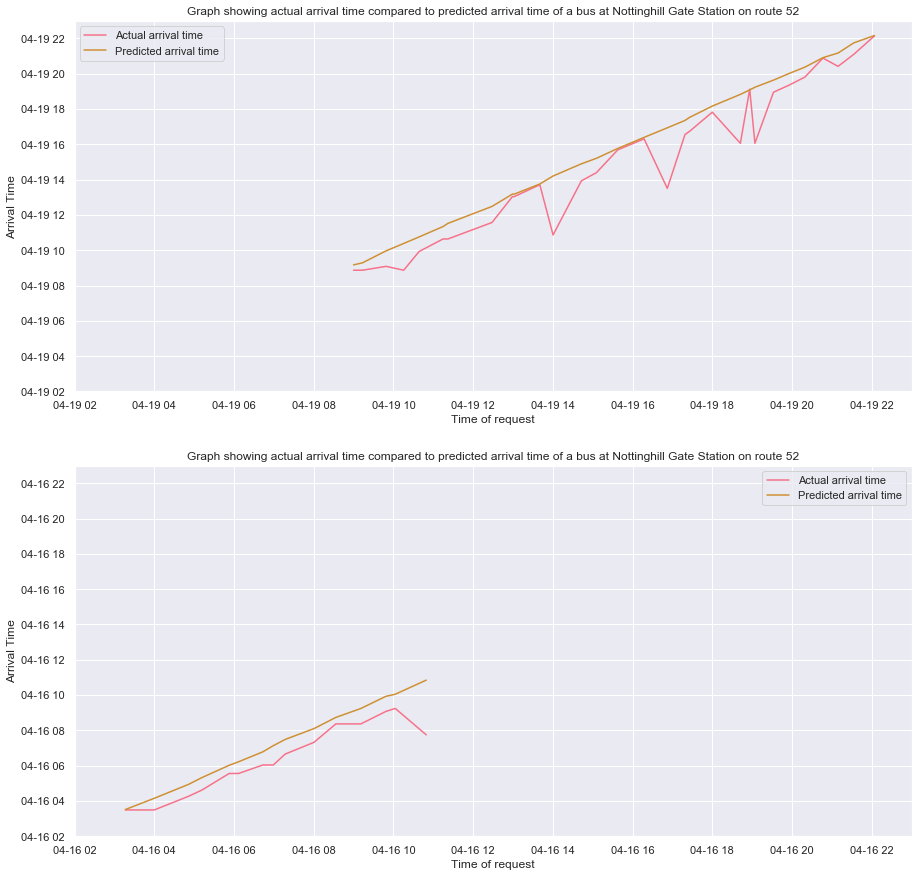

In [71]:
from sklearn.metrics import mean_squared_error

actual_52_160420 = [convert_time_to_datetime(a) for a in accs_52_160420]
times_52_160420 = [convert_time_to_datetime(t) for t in req_timesx_52_160420]

# mse = mean_squared_error(actual_52_160420, preds_52_160420)
# print("Mean Squared Error: ", mse)

actual_52_190420 = [convert_time_to_datetime(a) for a in accs_52_190420]
times_52_190420 = [convert_time_to_datetime(t) for t in req_timesx_52_190420]

fig, ax = plt.subplots(figsize=(15,15), nrows=2, ncols=1)
ax[0].plot(times_52_190420, actual_52_190420, label="Actual arrival time")
ax[0].plot(times_52_190420, preds_52_190420, label="Predicted arrival time")
ax[0].set_xlabel("Time of request")
ax[0].set_ylabel("Arrival Time")
ax[0].set_ylim([dt.datetime(2020, 4, 19, 2), dt.datetime(2020, 4, 19, 22, 59, 59)])
ax[0].set_xlim([dt.datetime(2020, 4, 19, 2), dt.datetime(2020, 4, 19, 22, 59, 59)])
ax[0].set_title("Graph showing actual arrival time compared to predicted arrival time of a bus at Nottinghill Gate Station on route 52")
ax[0].legend()

ax[1].plot(times_52_160420, actual_52_160420, label="Actual arrival time")
ax[1].plot(times_52_160420, preds_52_160420, label="Predicted arrival time")
ax[1].set_xlabel("Time of request")
ax[1].set_ylabel("Arrival Time")
ax[1].set_ylim([dt.datetime(2020, 4, 16, 2), dt.datetime(2020, 4, 16, 22, 59, 59)])
ax[1].set_xlim([dt.datetime(2020, 4, 16, 2), dt.datetime(2020, 4, 16, 22, 59, 59)])
ax[1].set_title("Graph showing actual arrival time compared to predicted arrival time of a bus at Nottinghill Gate Station on route 52")
ax[1].legend()
plt.show()

### "Warwick Avenue Station" to "Trafalgar Square" (outbound) for bus 6

In [72]:
print(stops_in_sequence_outbound.get("6").index("Warwick Avenue Station"))
print(stops_in_sequence_outbound.get("6").index("Trafalgar Square"))

18
34


In [73]:
b_6 = data["6"]
warwick_avn = b_6.loc[(b_6['bus_stop_name'] == 'Warwick Avenue Station') & (b_6['direction'] == 'outbound')]
[_, warwick_avn_id, _, _, _] = warwick_avn.iloc[0]['vehicle_id'].split('_')
print(warwick_avn.shape)
print(warwick_avn_id)
warwick_avn.head()

(1135, 5)
490000253H


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
26,Warwick Avenue Station,2020-04-02 16:24:18,10632_490000253H_2020-04-02_in_5,2020-04-02 16:18:45,outbound
32,Warwick Avenue Station,2020-04-02 16:33:36,9976_490000253H_2020-04-02_in_3,2020-04-02 16:32:45,outbound
54,Warwick Avenue Station,2020-04-02 09:59:02,10801_490000253H_2020-04-02_in_0,2020-04-02 09:50:46,outbound
243,Warwick Avenue Station,2020-04-02 12:09:18,10268_490000253H_2020-04-02_in_1,2020-04-02 11:52:47,outbound
343,Warwick Avenue Station,2020-04-05 15:18:48,11479_490000253H_2020-04-05_in_0,2020-04-05 15:18:45,outbound


In [74]:
trafalgar_sqr = b_6.loc[(b_6['bus_stop_name'] == 'Trafalgar Square') & (b_6['direction'] == 'outbound')]
[_, trafalgar_sqr_id, _, _, _] = trafalgar_sqr.iloc[0]['vehicle_id'].split('_')
print(trafalgar_sqr.shape)
print(trafalgar_sqr_id)
trafalgar_sqr.head()

(1105, 5)
490013767S


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
0,Trafalgar Square,2020-04-02 20:44:09,10275_490013767S_2020-04-02_in_6,2020-04-02 20:40:08,outbound
4,Trafalgar Square,2020-04-06 07:32:33,19669_490013767S_2020-04-06_in_1,2020-04-06 07:26:32,outbound
34,Trafalgar Square,2020-04-02 09:58:04,10268_490013767S_2020-04-02_in_0,2020-04-02 09:50:47,outbound
40,Trafalgar Square,2020-04-05 15:49:36,11483_490013767S_2020-04-05_in_0,2020-04-05 15:40:47,outbound
144,Trafalgar Square,2020-04-02 06:11:23,11808_490013767S_2020-04-02_in_0,2020-04-02 06:09:17,outbound


In [42]:
preds_52_160420 = []
accs_52_160420 = []
req_times_52_160420 = ["2020-04-16 02:58:12", "2020-04-16 03:16:27", "2020-04-16 03:59:55", "2020-04-16 04:51:36", "2020-04-16 05:11:55","2020-04-16 05:52:43", "2020-04-16 06:07:01", "2020-04-16 06:43:22", "2020-04-16 06:59:11", "2020-04-16 07:17:02", "2020-04-16 08:00:22", "2020-04-16 08:33:18", "2020-04-16 09:10:54", "2020-04-16 09:48:37", "2020-04-16 10:02:43", "2020-04-16 10:49:21"]
req_timesx_52_160420 = []

for req_time in req_times_52_160420:
    p, a = pred_eval_arrival_times(req_time, all_souls_avn, ntg_stn, all_souls_avn_id, ntg_stn_id)
    if a == 0:
        continue
    req_timesx_52_160420.append(req_time)
    preds_52_160420.append(p)
    accs_52_160420.append(a)

REQ TIME:  2020-04-16 02:58:12
Time taken:  0.07472705841064453
The predicted journey time for a bus from All Souls Avenue to Notting Hill Gate Station is 0.00 minutes
The estimated leave time of a bus requested at 2020-04-16 02:58:12 is 2020-04-16 02:58:12
There is no bus due
Cannot find correlating bus.
REQ TIME:  2020-04-16 03:16:27
Time taken:  0.18253302574157715
The predicted journey time for a bus from All Souls Avenue to Notting Hill Gate Station is 3.27 minutes
The estimated leave time of a bus requested at 2020-04-16 03:16:27 is 2020-04-16 03:13:10.500000
2020-04-16 03:17:18
The predicted arrival time at Notting Hill Gate Station for a bus requested at 2020-04-16 03:16:27 is 2020-04-16 03:21:04.500000
Actual arrival time is 2020-04-16 03:29:24
Predicted arrival time is 2020-04-16 03:21:04.500000
REQ TIME:  2020-04-16 03:59:55
Time taken:  0.3719370365142822
The predicted journey time for a bus from All Souls Avenue to Notting Hill Gate Station is 12.80 minutes
The estimated l

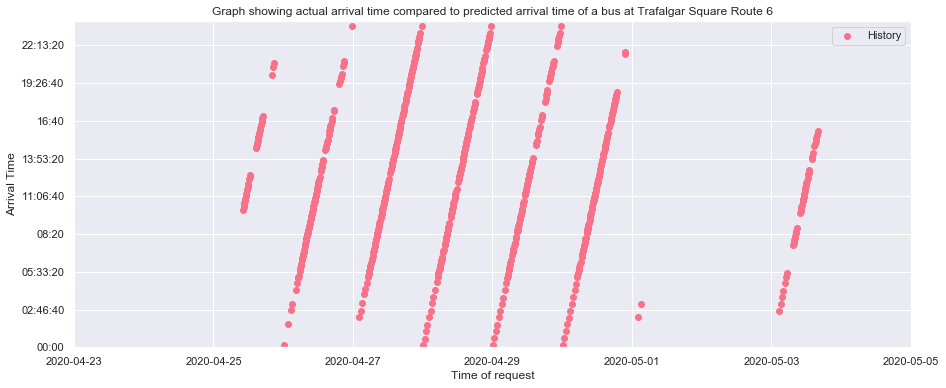

In [43]:
trafalgar_history = []
for i, item in trafalgar_sqr.iterrows():
    eta = convert_time_to_datetime(item.get('expected_arrival'))
    trafalgar_history.append(eta)
        
dates = [x.date() for x in trafalgar_history]
times = [x.time() for x in trafalgar_history]

fig, ax = plt.subplots(figsize=(15,6))
ax.scatter(trafalgar_history, times, label="History")
ax.set_ylim([dt.time(0), dt.time(23,59,59)])
ax.set_xlim([dt.datetime(2020, 4, 23), dt.datetime(2020, 5, 5)])
ax.set_xlabel("Time of request")
ax.set_ylabel("Arrival Time")
ax.set_title("Graph showing actual arrival time compared to predicted arrival time of a bus at Trafalgar Square Route 6")
ax.legend()
plt.show()

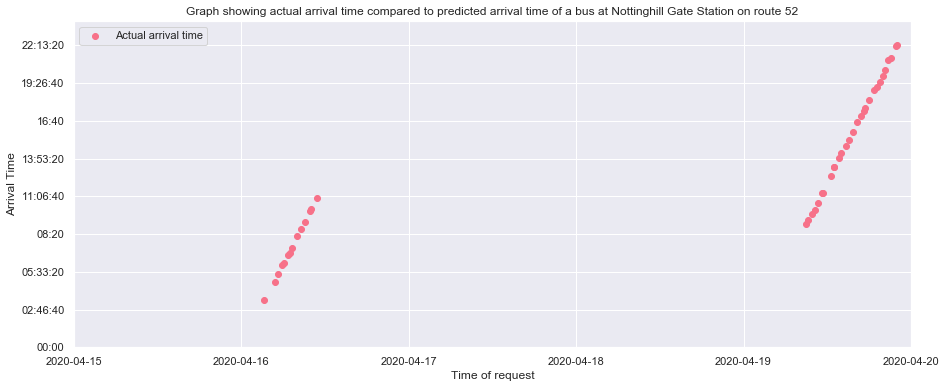

In [44]:
# Take away the date and give it an arbitrary date.
aggr_times = actual_52_160420 + actual_52_190420
aggr_times = [x.time() for x in aggr_times]

aggr_reqs = times_52_160420 + times_52_190420

fig, ax = plt.subplots(figsize=(15,6))
ax.scatter(aggr_reqs, aggr_times, label="Actual arrival time")
ax.set_ylim([dt.time(0), dt.time(23,59,59)])
ax.set_xlim([dt.datetime(2020, 4, 15), dt.datetime(2020, 4, 20)])
ax.set_xlabel("Time of request")
ax.set_ylabel("Arrival Time")
ax.set_title("Graph showing actual arrival time compared to predicted arrival time of a bus at Nottinghill Gate Station on route 52")
ax.legend()
plt.show()